<a href="https://colab.research.google.com/github/sarahajbane/colab_workbook_templates/blob/main/Car_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Dataset Analysis
Author: Sara Hajbane\
version: working_version02

# Cleaning Data

## Import libraries and data

In [52]:
# Import required libraries and functions
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from scipy.stats import chi2_contingency
import numpy as np

In [53]:
# Access raw data required
data = !wget -O 'data.csv' 'https://drive.google.com/uc?id=19V7VjHs4J8idTko7NQUT95ZJO2ZQSGWh'
df = pd.read_csv("/content/data.csv")
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


## Handle missing data

In [54]:
# Identify nulls, data types, and duplicated rows
df.info()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

715

Data Cleaning steps:

*   drop NaNs in Fuel Type (i.e. required)
*   imputate fields : Engine HP, Cylinders & Car doors (mode for categorical data, despite float)
*   Replace Market Category (most frequent null)





In [56]:
df_cleaned = df[df['Engine Fuel Type'].notna()] # create cleaned dataframe without NaN Fuel Types
df_cleaned.shape

(11911, 16)

In [55]:
for i in df_cleaned.isnull().sum():
  if i>0:
    print(i)

print('Duplicates:', df.duplicated().sum())

69
30
6
3373
Duplicates: 715


In [59]:
# save intermediary file in colab
df_cleaned.to_csv(f'cleaned_data_Sara_Hajbane.csv', index=False)
df_cleaned = df_cleaned.copy()

In [62]:
df_cleaned.drop_duplicates(inplace=True) # drop duplicates in the new dataframe
print(f'Remaining duplicates: {df_cleaned.duplicated().sum()}') # check duplicates

Remaining duplicates: 0


In [63]:
# Get the most frequent category in EHP to fill NaNs
df_cleaned.fillna({'Engine HP': df['Engine HP'].mode()[0]},inplace=True)
df_cleaned.fillna({'Engine Cylinders': df['Engine Cylinders'].mode()[0]},inplace=True)
df_cleaned.fillna({'Number of Doors': df['Number of Doors'].mode()[0]},inplace=True)
print(f'Remaining null values: {df_cleaned.isnull().sum()}')
## NOTE: when filling missing categorical values with the mode, 'mode()' returns a Series,
## so you need to access the first element of that Series, i.e. `df['Caterory'].mode()[0]`

Remaining null values: Make                    0
Model                   0
Year                    0
Engine Fuel Type        0
Engine HP               0
Engine Cylinders        0
Transmission Type       0
Driven_Wheels           0
Number of Doors         0
Market Category      3373
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64


In [ ]:
df_cleaned.rename(columns={'two':'new_name'}, inplace=True)

In [21]:
df_cleaned['Market Category'].describe()

,Market Category
count,7823
unique,71
top,Crossover
freq,1075


In [ ]:
#Check category correlation to decide how to handle null values in Market Sector


def cramers_V(var1, var2):
    crosstab = np.array(pd.crosstab(var1, var2))
    stats = chi2_contingency(crosstab)[0]
    cram_V = stats / (np.sum(crosstab) * (min(crosstab.shape) - 1))
    return cram_V

def cramers_col(column_name):
    col = pd.Series(np.empty(df_cleaned.columns.shape), index=df_cleaned.columns, name=column_name)
    for row in df_cleaned:
        cram = cramers_V(df_cleaned[column_name], df_cleaned[row])
        col[row] = round(cram, 2)
    return col

df_corr = df_cleaned.apply(lambda Market_Category : cramers_col('Market Category'))


In [ ]:
df_corr.Make # call any column (they all the same)
# highest chi = highest correlation for MSRP -  Manufacturer's Suggested Retail Price

,Make
Make,0.14
Model,0.55
Year,0.03
Engine Fuel Type,0.47
Engine HP,0.32
Engine Cylinders,0.18
Transmission Type,0.17
Driven_Wheels,0.27
Number of Doors,0.25
Market Category,1.00


<Axes: xlabel='MSRP', ylabel='Count'>

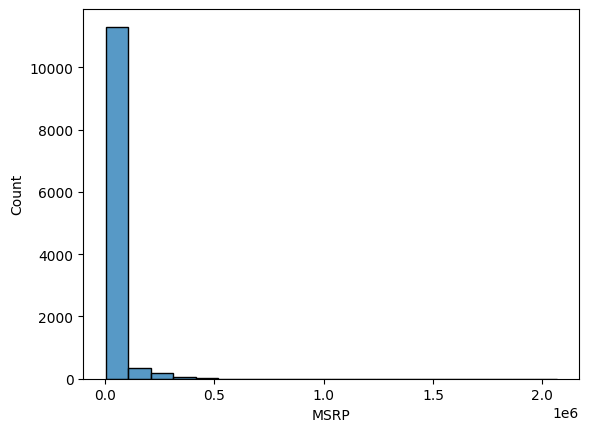

In [ ]:
df_cleaned['MSRP'].describe()
sns.histplot(df_cleaned['MSRP'], bins=20)

<Axes: xlabel='Market Category', ylabel='MSRP'>

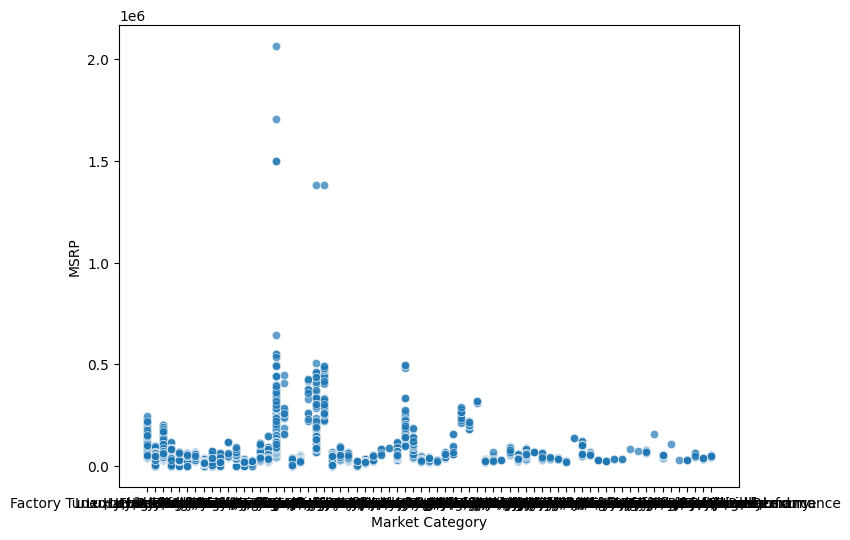

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cleaned, x='Market Category', y='MSRP', alpha=0.7)
# sns.boxplot(data=df_cleaned, x='Market Category', y='MSRP')
# Group Market Categories with multiple Cats

In [ ]:
ox

# Save Cleaned Data for Download

In [5]:
# Save the cleaned dataset locally
df_cleaned = df.copy()
student_name = 'Sara_Hajbane'
df_cleaned.to_csv(f'cleaned_data_{student_name}.csv', index=False)

# Allow download for manual upload
# files.download(f'cleaned_data_{student_name}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualizing the Data

In [ ]:
# Distribution of miles per gallon in the city (City mpg)

# Correlation Analysis

